In [19]:
import pickle
import os

FOLDER = os.getcwd() + "/5cell_test"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)
with open(FOLDER+'/sourcePts.pkl', 'rb') as file:   
    sourcePts = pickle.load(file)
(maskWidth, maskHeight) = mask.shape


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [22]:
class Net(nn.Module):
    def __init__(self,N,output_intensity=None):
        super(Net, self).__init__()
        self.polynomial_degree = 7
        self.polynomial_weights = nn.Linear(self.polynomial_degree,1,bias=False)
        self.polynomial_weights.weight.data[0][0] = -10
        self.actual_intensity = nn.Linear(N,1,bias=False)
        if output_intensity is not None:
            for i in range(N):
                self.actual_intensity.weight.data[0][i] = output_intensity[i]
    def getPSF(self,x):
        stack = []
        for i in range (1, self.polynomial_degree+1):
            stack.append(torch.pow(x,2*i))
        x = torch.stack(stack, dim=2)
        x = self.polynomial_weights(x)
        x = x.reshape(x.shape[0],x.shape[1])
        x = torch.exp(x)
        return x
        
    def forward(self, x):
        x = self.getPSF(x)
        x = self.actual_intensity(x)
        return x


In [23]:
#Load checkpoint
checkpoint = torch.load(FOLDER + "/model-20230917-110529.pt")
model = Net(checkpoint['N'])
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

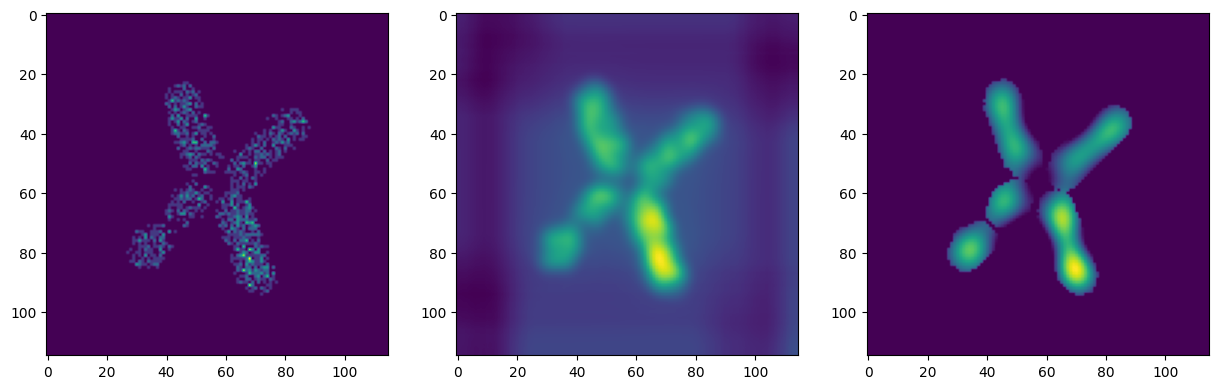

In [24]:
#Recreate original image based off of calculated intensity

customOriginal = np.zeros((maskWidth,maskHeight))
modelIntensity = model.actual_intensity.weight.data[0]
for i in range(len(modelIntensity)):
    customOriginal[sourcePts[i][0]][sourcePts[i][1]] = modelIntensity[i]

oriNormalised = np.asanyarray(ori)
oriNormalised = oriNormalised / max(oriNormalised.flatten())

outNormalised = np.asanyarray(out)
outNormalised = outNormalised / max(outNormalised.flatten())

customOriginal = customOriginal / max(customOriginal.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(oriNormalised)
axarr[1].imshow(outNormalised)
axarr[2].imshow(customOriginal)